In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [10]:
from ranking_funcs import filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [42]:
book_df=pd.read_csv('Amazon_Books_Data.csv')
bk_df=book_df.iloc[:,:12]
bk_df.loc[~bk_df['best_seller'].isin(['Yes', 'No']), 'best_seller'] = np.nan
bk_df['best_seller'] = bk_df['best_seller'].replace({'Yes': 1, 'No': 0}).astype(float)
bk_df['price'] = bk_df['price'].str.replace('$', '').astype(float)
bk_df['rating'] = pd.to_numeric(bk_df['rating'], errors='coerce')
bk_df['review_count'] = pd.to_numeric(bk_df['review_count'], errors='coerce')
bk_df['edition'] = pd.to_numeric(bk_df['edition'], errors='coerce')

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_95041/2943498763.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bk_df['price'] = bk_df['price'].str.replace('$', '').astype(float)


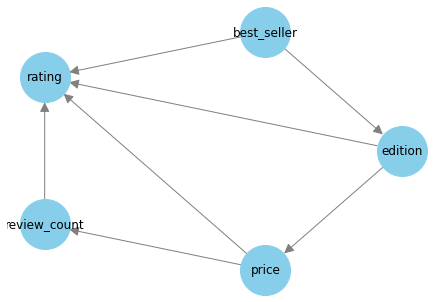

In [12]:
nodes = ['edition', 'best_seller', 'rating', 'review_count', 'price']
edges = [('edition', 'price'),
         ('edition', 'rating'),
         ('price', 'rating'),
         ('best_seller', 'rating'),
         ('best_seller', 'edition'),
         ('review_count','rating'),
         ('price','review_count')]

G_book = nx.DiGraph()


G_book.add_nodes_from(nodes)
G_book.add_edges_from(edges)


layout = nx.circular_layout(G_book)

nx.draw(G_book, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

plt.savefig(f'ranking_plots/causal_graph_amazon_book.png')
plt.show()

In [5]:
new_G_book=get_new_G(G_book,bk_df)

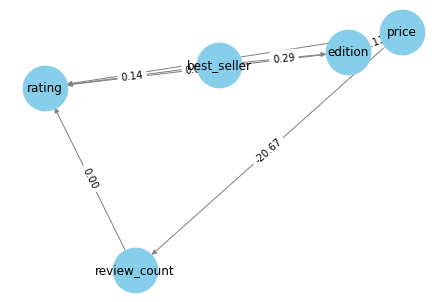

In [6]:
pos = nx.spring_layout(new_G_book)
nx.draw(new_G_book, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G_book.edges(data=True)}
nx.draw_networkx_edge_labels(new_G_book, pos, edge_labels=edge_labels)
plt.show()

### Update price to 5 for edition=1 to rank the rating

In [8]:
bk_df.sort_values(by='rating',ascending=False).head(3)

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
159,C# & C++,5 Books in 1 - The #1 Coding Course from Begin...,Mark Reed,NaN,979-8390090077,2023-04-10,1.0,1.0,No,5.0,320.0,38.82
52,Java,The Ultimate Beginner's Guide to Learn Java Qu...,Mark Reed,NaN,979-8387893131,2023-03-21,1.0,0.0,No,5.0,160.0,24.99
413,Cloud Governance:,Basics and Practice (Professors of Practice) (...,Steven Mezzio,3110755262,978-3110755268,2022-12-05,1.0,NaN,No,5.0,4.0,29.99


In [7]:
top_3_ranking_fix=get_ranking_query(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},opt='fix')
top_3_ranking_fix

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
225,Learning eBPF,Programming the Linux Kernel for Enhanced Obse...,Liz Rice,1098135121,978-1098135126,2023-04-11,1.0,0.0,No,5.249291,995.873069,5.0
451,Certified Ethical Hacker (CEH) v12 312-50 Exam...,Keep up to date with ethical hacking trends an...,Dale Meredith,1801813094,978-1801813099,8-Jul-22,1.0,0.0,No,5.207734,831.526444,5.0
321,Configuring Windows Server Hybrid Advanced Ser...,Configure advanced Windows Server services for...,Chris Gill,1804615099,978-1804615096,2023-04-28,1.0,0.0,No,5.207734,828.526444,5.0


### Baseline
- our baseline is $\frac{1}{^nP_k}$ for all pwd where k is the top k and n is the length of the data.

In [8]:
base_line(bk_df,3)

6.350679706898349e-09

### Simulating ranking probility

In [9]:
top_3_ranking_prob_fix = get_ranking_query_prob(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},opt='fix')
top_3_ranking_prob_fix

,row_index,1,2,3
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,2,0,0.0,0.0
3,3,0,0.0,0.0
4,4,0,0.0,0.0
...,...,...,...,...
536,536,0,0.0,0.0
537,537,0,0.0,0.0
538,538,0,0.0,0.0
539,539,0,0.0,0.0


In [10]:
top_3_ranking_prob_fix_filtered=filter_prob_df(top_3_ranking_prob_fix)
top_3_ranking_prob_fix_filtered

,row_index,1,2,3
225,225,1,0.0,0.0
321,321,0,0.5,0.5
451,451,0,0.5,0.5


In [11]:
calc_prob(top_3_ranking_prob_fix_filtered,6)

[{'ranking_combos': (225, 321, 451), 'probabilities': 0.5},
 {'ranking_combos': (225, 451, 321), 'probabilities': 0.5},
 {'ranking_combos': (321, 225, 451), 'probabilities': 0.0},
 {'ranking_combos': (321, 451, 225), 'probabilities': 0.0},
 {'ranking_combos': (451, 225, 321), 'probabilities': 0.0},
 {'ranking_combos': (451, 321, 225), 'probabilities': 0.0}]

### Stable ranking

In [12]:
stable_rank_fix=get_stable_ranking_opt(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},100,'fix')
stable_rank_fix

[[None, 12.850306503581141], [None, 51]]

#### Verify the ranking by 0.01 std(y) to check having the same ranking

In [13]:
x_sd=np.abs(bk_df['price'].std() * 0.01)

In [44]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':12.850306503581141-x_sd},
                      'rating',{'edition':1},opt='fix').index==top_3_ranking_fix.index)

True

#### Check the ranking whether will go back to the orginal ranking

In [15]:
get_test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},
                            stable_rank_fix,1000,0,3,'uper','fix')

[26.088078254717967, 137, 'update upper']
26.088078254717967
Lower Bound Change: (Value: 25.934150676216376, Iteration: 1)
Upper Bound Change: (Value: 33.01481928728954, Iteration: 45)
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

In [113]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':26.088078254717967},
                  'rating',{'edition':1},opt='fix').index==top_3_ranking_fix.index)

True

In [43]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':33.01481928728954-x_sd},
                  'rating',{'edition':1},opt='fix').index==top_3_ranking_fix.index)

True

#### Group ranking

In [25]:
rank_rating_by_ed=get_ranking_query_prob_grouped(new_G_book, bk_df, 3, {'price':5}, 'rating','edition',{'edition':1},'fix')
rank_rating_by_ed_filtered=filter_prob_df_grouped(rank_rating_by_ed)
rank_rating_by_ed_filtered

,group_col,1,2,3
5,6.0,1,0.0,0.0
7,8.0,0,0.5,0.5
8,10.0,0,0.5,0.5


In [26]:
calc_prob(rank_rating_by_ed_filtered,6)

[{'ranking_combos': (5, 7, 8), 'probabilities': 0.5},
 {'ranking_combos': (5, 8, 7), 'probabilities': 0.5},
 {'ranking_combos': (7, 5, 8), 'probabilities': 0.0},
 {'ranking_combos': (7, 8, 5), 'probabilities': 0.0},
 {'ranking_combos': (8, 5, 7), 'probabilities': 0.0},
 {'ranking_combos': (8, 7, 5), 'probabilities': 0.0}]

### Update price by 2 times for edition=1 to rank the rating

In [67]:
top_3_ranking_multi=get_ranking_query(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},opt='multiply_by')
top_3_ranking_multi

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
35,Rust Web Programming,"A hands-on guide to developing, packaging, and...",Maxwell Flitton,1803234695,978-1803234694,2023-01-27,2.0,1.0,No,5.0,4.0,44.99
125,Rust Web Programming,"A hands-on guide to developing, packaging, and...",Maxwell Flitton,1803234695,978-1803234694,2023-01-27,2.0,0.0,No,5.0,5.0,44.99
189,SQL,The #1 Crash Course for Beginners to Master SQ...,James Howard,NaN,979-8394081941,2023-05-10,NaN,0.0,No,5.0,133.0,19.99


### Simulating ranking probility

In [73]:
top_3_ranking_prob_multi = get_ranking_query_prob(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},opt='multiply_by')
top_3_ranking_prob_multi

,row_index,1,2,3
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
...,...,...,...,...
536,536,0.0,0.0,0.0
537,537,0.0,0.0,0.0
538,538,0.0,0.0,0.0
539,539,0.0,0.0,0.0


In [74]:
top_3_ranking_prob_multi_filtered=filter_prob_df(top_3_ranking_prob_multi)
top_3_ranking_prob_multi_filtered

,row_index,1,2,3
35,35,0.166667,0.166667,0.166667
125,125,0.166667,0.166667,0.166667
189,189,0.166667,0.166667,0.166667
294,294,0.166667,0.166667,0.166667
310,310,0.166667,0.166667,0.166667
312,312,0.166667,0.166667,0.166667


In [75]:
probs_multi=calc_prob(top_3_ranking_prob_multi_filtered,120)

probs_multi[1:10]

[{'ranking_combos': (35, 125, 294), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 125, 310), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 125, 312), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 125), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 294), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 310), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 312), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 294, 125), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 294, 189), 'probabilities': 0.008333333333333318}]

### Stable ranking

In [76]:
stable_rank_multi=get_stable_ranking_opt(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},100,'multiply_by')
stable_rank_multi

Lower Bound Change: (Value: 1.7332110240376257, Iteration: 1)
Upper Bound Change: (Value: 2.66309771285309, Iteration: 2)


[[1.7332110240376257, 2.66309771285309], [1, 2]]

#### Verify the ranking by 0.01 std(y) to check having the same ranking

In [127]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':1.7332110240376257*(1+x_sd)}, 'rating',{'edition':1},
                           opt='multiply_by').index==top_3_ranking_multi.index)


True

In [99]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':2.66309771285309/(1+x_sd)}, 'rating',{'edition':1},
                           opt='multiply_by').index==top_3_ranking_multi.index)

True

#### Check the ranking whether will go back to the orginal ranking

In [146]:
get_test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},
                            stable_rank_multi,1000,0,3,'uper','multiply_by')

no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

In [145]:
get_test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},
                            stable_rank_multi,1000,0,3,'lower','multiply_by')

no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

#### Group ranking

In [147]:
rank_rating_by_ed=get_ranking_query_prob_grouped(new_G_book, bk_df, 3, {'price':2}, 'rating','edition',{'edition':1},'multiply_by')
rank_rating_by_ed_filtered=filter_prob_df_grouped(rank_rating_by_ed)
rank_rating_by_ed_filtered

,group_col,1,2,3
5,6.0,1,0.0,0.0
7,8.0,0,0.5,0.5
8,10.0,0,0.5,0.5


In [148]:
calc_prob(rank_rating_by_ed_filtered,6)

[{'ranking_combos': (5, 7, 8), 'probabilities': 0.5},
 {'ranking_combos': (5, 8, 7), 'probabilities': 0.5},
 {'ranking_combos': (7, 5, 8), 'probabilities': 0.0},
 {'ranking_combos': (7, 8, 5), 'probabilities': 0.0},
 {'ranking_combos': (8, 5, 7), 'probabilities': 0.0},
 {'ranking_combos': (8, 7, 5), 'probabilities': 0.0}]

In [7]:
top_3_ranking_prob_multi = get_ranking_query_prob(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},opt='multiply_by')
top_3_ranking_prob_multi

,row_index,1,2,3
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
...,...,...,...,...
536,536,0.0,0.0,0.0
537,537,0.0,0.0,0.0
538,538,0.0,0.0,0.0
539,539,0.0,0.0,0.0


In [8]:
top_3_ranking_prob_multi_filtered=filter_prob_df(top_3_ranking_prob_multi)
top_3_ranking_prob_multi_filtered

,row_index,1,2,3
35,35,0.166667,0.166667,0.166667
125,125,0.166667,0.166667,0.166667
189,189,0.166667,0.166667,0.166667
294,294,0.166667,0.166667,0.166667
310,310,0.166667,0.166667,0.166667
312,312,0.166667,0.166667,0.166667


In [43]:
df=bk_df.copy().dropna()

In [114]:
def review_count_category(review_count):
    if review_count <= 100: return 0
    elif review_count <= 1000: return 1
    elif review_count <= 10000: return 2
    else: return 3
df['review_count'] = df['review_count'].astype(int).apply(review_count_category)

def price_category(price):
    if price <= 10: return 0
    elif price <= 50: return 1
    elif price <= 100: return 2
    else: return 3
df['price'] = df['price'].astype(int).apply(price_category)

df['rating'] = round(df['rating'], 0)

In [115]:
import ranking_funcs

In [116]:
X=df[['edition', 'best_seller', 'review_count', 'price']]
y=df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [117]:
%%capture
###random forest with variables selected by the importance plot
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt',4],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(rf,param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

In [118]:
rf_estimator=RandomForestRegressor(**rf_cv.best_params_, random_state=123).fit(X, y)

In [119]:
for n in nodes:
    print((n,ranking_funcs.find_backdoor_sets_opt(new_G_book, "rating", n)))

('edition', [frozenset({'best_seller'})])
('best_seller', None)
('rating', None)
('review_count', [frozenset({'price'})])
('price', [frozenset({'edition'})])


In [138]:
updated_df=get_ranking_query(new_G_book, df, len(df), {'price':1}, 'rating',{'edition':1},opt='fix')

In [139]:
updated_df_X=updated_df[['edition', 'best_seller', 'review_count', 'price']]
updated_df_y=updated_df['rating']

In [140]:
rf_result=rf_estimator.predict(updated_df_X)

In [141]:
updated_df['rf_prediction']=rf_result

In [142]:
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)
rf_order

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price,rf_prediction
17,"Automate the Boring Stuff with Python, 2nd Edi...",Practical Programming for Total Beginners,Al Sweigart,1593279922,978-1593279929,2019-11-12,2.0,1.0,No,5.0,0.0,0,4.926552
206,"The Linux Command Line, 2nd Edition",A Complete Introduction,William Shotts,1593279523,978-1593279523,2019-03-07,2.0,1.0,No,5.0,0.0,0,4.926552
10,The Pragmatic Programmer,"Your Journey To Mastery, 20th Anniversary Edit...",David Thomas,135957052,978-0135957059,2019-09-13,2.0,1.0,No,5.0,0.0,0,4.926552
37,Programming Rust,"Fast, Safe Systems Development",Jim Blandy,1492052590,978-1492052593,2021-07-20,2.0,1.0,No,5.0,0.0,0,4.926552
6,"Automate the Boring Stuff with Python, 2nd Edi...",Practical Programming for Total Beginners,Al Sweigart,1593279922,978-1593279929,2019-11-12,2.0,1.0,No,5.0,0.0,0,4.926552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Computer Systems,"A Programmer's Perspective, 3 Edition",David R. O'Hallaron Randal E. Bryant,9332573905,978-9332573901,2016-01-01,3.0,0.0,No,4.0,0.0,0,4.353606
76,Hands-On Unity 2022 Game Development,Learn to use the latest Unity 2022 features to...,Nicolas Alejandro Borromeo,1803236914,978-1803236919,2022-10-31,3.0,0.0,No,5.0,0.0,0,4.353606
246,Assembly Language Step-by-Step,Programming with Linux,Jeff Duntemann,470497025,978-0470497029,2009-10-05,3.0,0.0,No,4.0,0.0,0,4.353606
318,Mastering Active Directory,"Design, deploy, and protect Active Directory D...",Dishan Francis,1801070393,978-1801070393,2021-11-30,3.0,0.0,No,5.0,0.0,0,4.353606


In [143]:
true_top_3=updated_df.head(3).index
true_top_3

Int64Index([60, 142, 53], dtype='int64')

In [144]:
top_3_rf = rf_order.head(3).index
top_3_rf

Int64Index([17, 206, 10], dtype='int64')

In [145]:
ranking_funcs.accuracy_in_topk(top_3_rf,true_top_3)

0.0

In [146]:
ranking_funcs.accuracy_topk_rank(top_3_rf,true_top_3)

0.0

In [147]:
new_G=ranking_funcs.get_new_G(G_book,df)
new_G_combined=ranking_funcs.get_new_G_combined(G_book,df)

In [148]:
backdoor_2_preds=ranking_funcs.predict_backdoor_opt2(new_G, df, len(df), {'price':1}, 'rating',{'edition':1},opt='fix')

In [149]:
backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined, df, len(df),{'price':1}, 'rating',{'edition':1},opt='fix')

In [150]:
backdoor_1_preds=ranking_funcs.predict_backdoor_opt(new_G, df, len(df),{'price':1}, 'rating',{'edition':1},opt='fix')

In [151]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined, df, len(df), {'price':1}, 'rating',{'edition':1},opt='fix')

In [265]:
rf_results=[]
rf_results_in_topk=[]

back_door_opt1_with_G=[]
back_door_opt1_with_G_in_topk=[]

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_G=[]
back_door_opt2_with_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))

    back_door_opt1_with_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))

In [266]:
df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method1':back_door_opt1_with_G,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G,
                               'backdoor_method2':back_door_opt2_with_G,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                               'k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method1':back_door_opt1_with_G_in_topk,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G_in_topk,
                               'backdoor_method2':back_door_opt2_with_G_in_topk,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                'k_range':range(1,len(updated_df)+1)})

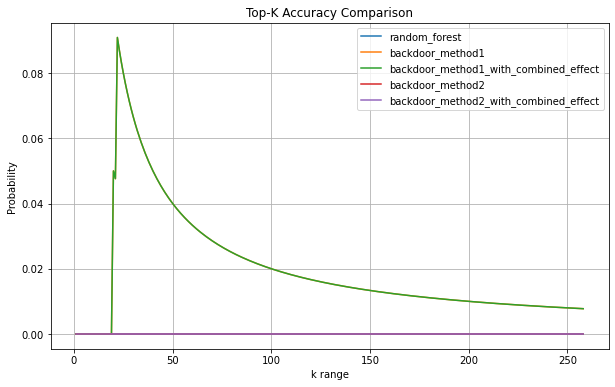

In [267]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison_amazon.png')

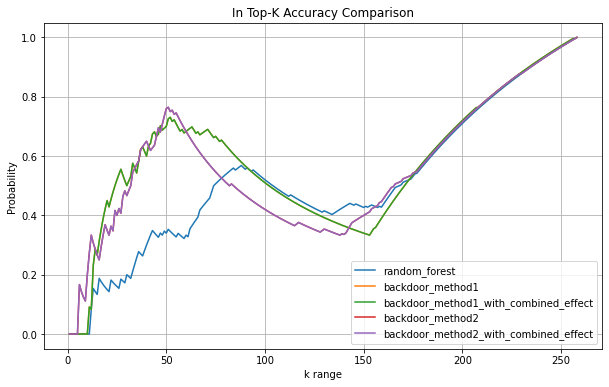

In [268]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison_amazon.png')
plt.show()

In [161]:
updated_df['true_row_index']=updated_df.index

In [162]:
rf_order['true_row_index']=rf_order.index

In [166]:
rf_row_indexes=rf_order.groupby('edition').apply(lambda d: d['true_row_index'].to_list())

In [ ]:
rf_row_indexes

edition
1.0     [25, 21, 20, 8, 7, 28, 30, 24, 34, 455, 423, 0...
2.0     [17, 206, 10, 37, 6, 35, 244, 79, 465, 83, 296...
3.0     [2, 14, 16, 12, 81, 363, 64, 213, 273, 297, 29...
4.0                          [299, 53, 90, 254, 315, 458]
5.0                                             [51, 231]
6.0                                    [1, 456, 107, 314]
7.0                                          [94, 93, 74]
10.0                                                [155]
dtype: object

In [ ]:
rf_row_indexes[0:1]

edition
1.0    [25, 21, 20, 8, 7, 28, 30, 24, 34, 455, 423, 0...
dtype: object

In [163]:
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')
merged_df['true_row_index']=merged_df.index

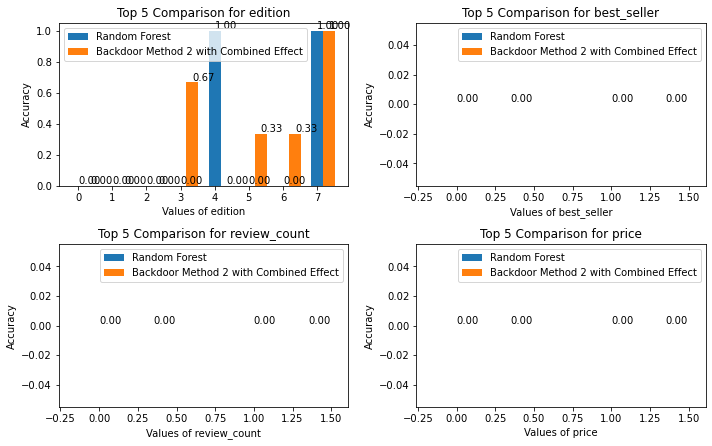

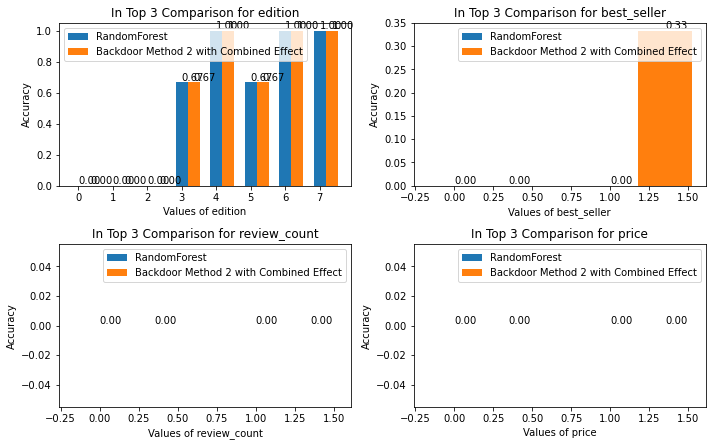

In [179]:
Xs =['edition', 'best_seller', 'review_count', 'price']


plt.figure(figsize=(10, 3 * len(Xs)))


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
    for i in true_row_indexes.index:
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        
        x_val.append(i)
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                      x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.35
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, label='Random Forest')
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_3_comparison_all_features_amazon.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
    for i in true_row_indexes.index:
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        
        x_val.append(i)
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                      x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.35
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, label='RandomForest')
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 3 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_3_comparison_all_features_amazon.png')
plt.show()

In [191]:
var=['review_count']
df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df, 3, 'rating',var,0, {'edition':2},100, "add",2)
df_gr

,rank,prob,total_iters
0,"[0, 232, 208]",1.0,100.0


In [192]:
row_indexes=[0, 232, 208]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 3, 'rating',var,1, {'edition':2} ,100, "add",2)

In [193]:
np.sum(greedy_backdoor)/100

0.2085523916133171

In [194]:
np.sum(greedy_backdoor2)/100

0.2085523916133171

In [195]:
baseline_val=ranking_funcs.base_line(df,5)**5
baseline_val

6.225389684243624e-61

In [196]:
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G, df, 3, 'rating',var,1, {'edition':2} ,100, "add",2)

In [197]:
np.sum(greedy_backdoor)/100

0.2085523916133171

In [198]:
np.sum(greedy_backdoor2)/100

0.2085523916133171

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_95041/453197529.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)
/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_95041/453197529.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)


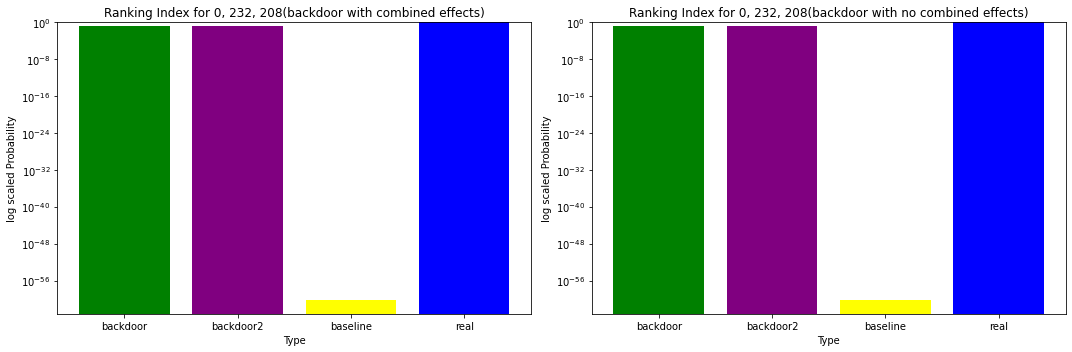

In [199]:
data1 = {'backdoor': 0.2085523916133171,'backdoor2': 0.2085523916133171, 'baseline':baseline_val,'real': 1}
data2 = {'backdoor': 0.2085523916133171,'backdoor2':0.2085523916133171,  'baseline':baseline_val,'real': 1}

data=[data1, data2]

types = ['backdoor','backdoor2','baseline','real']
colors = {'backdoor': 'green', 'backdoor2':'purple','baseline': 'yellow','real': 'blue'}

titles = [
    "Ranking Index for 0, 232, 208(backdoor with combined effects)",
    "Ranking Index for 0, 232, 208(backdoor with no combined effects)"
]


fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

for i, d in enumerate(data):
    axes[i].bar(types, [d[t] for t in types], color=[colors[t] for t in types])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Type')
    axes[i].set_xticks(types)
    axes[i].set_ylabel('log scaled Probability')
    axes[i].set_yscale('log')
    max_val = max(d.values())
    axes[i].set_ylim(0, max_val)  

plt.tight_layout()
plt.savefig(f'ranking_plots/greedy_cgs_amazon.png')
plt.show()

In [218]:
def k_range_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes,end_k):
    back_result=[]
    back2_result = []
    for z in range(k,end_k+1):
        updated_df=get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
        theta=updated_df[target_column].iloc[z-1]
        back_result.append(ranking_funcs.get_prob_backdoor_opt(G, df, z, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        back2_result.append(ranking_funcs.get_prob_backdoor_opt2(G, df, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
    return back_result,back2_result

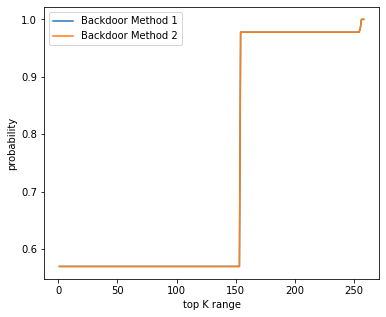

In [219]:
#The Staff Engineer's Path
k_range_backdoor_val,k_range_backdoor2_val=k_range_backdoor(new_G, df, 1, {'price':1}, 'rating', {'edition':1}, 'fix', [0],len(df))
x_values = range(1, len(df)+1)    
plt.figure(figsize=(6, 5))
plt.plot(x_values, k_range_backdoor_val, label='Backdoor Method 1')
plt.plot(x_values, k_range_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('top K range')
plt.ylabel('probability')
plt.legend()

plt.savefig(f'ranking_plots/topk_range_backdoor_amazon.png')
plt.show()

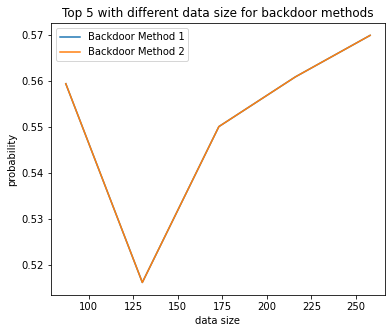

In [220]:
lenth,data_size_backdoor_val,data_size_backdoor2_val=ranking_funcs.data_size_backdoor(new_G, df, 3, {'price':1}, 'rating', {'edition':1}, 'fix', [0],6,123)
plt.figure(figsize=(6, 5))
plt.plot(lenth, data_size_backdoor_val, label='Backdoor Method 1')
plt.xlabel('data size')
plt.ylabel('probability')

plt.plot(lenth, data_size_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('data size')
plt.ylabel('probability')
plt.title(f'Top 5 with different data size for backdoor methods')
plt.legend()

plt.savefig(f'ranking_plots/topk_backdoor_range_amazon.png')
plt.show()

In [200]:
import time

In [201]:
df_subsets=df.head(50)
iter_times=[10,50,100,150,200,250,300,350]
var=['review_count']
time_greedy_algo=[]

for i in iter_times:
    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df_subsets, 3, 'rating',var,0, {'edition':2},i, "add",2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)

In [204]:
time_greedy_backdoor=[]
row_indexes=[0, 1, 2, 7, 8]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G, df_subsets, 3, 'rating',var,1, {'edition':2} ,i, "add",2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)

In [208]:
def Comp_Greedy_Algo_backdoor2(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    prob_result2=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result2

In [209]:
time_greedy_backdoor2=[]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G, df_subsets, 3, 'rating',var,1, {'edition':2} ,i, "add",2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)

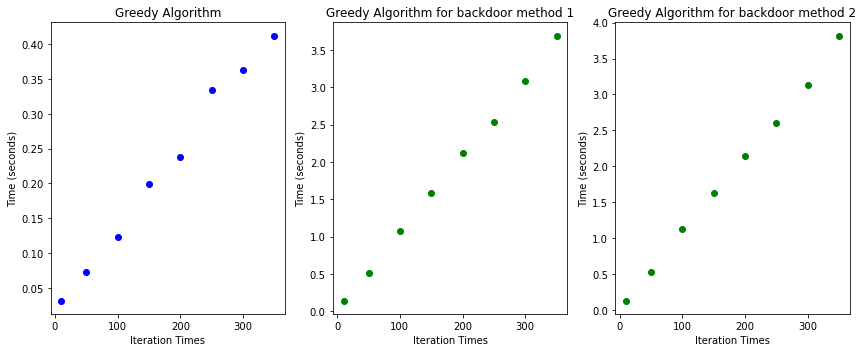

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

axes[0].scatter(x=iter_times, y=time_greedy_algo, color='blue')
axes[0].set_title('Greedy Algorithm')
axes[0].set_xlabel('Iteration Times')
axes[0].set_ylabel('Time (seconds)')

axes[1].scatter(x=iter_times, y=time_greedy_backdoor, color='green')
axes[1].set_title('Greedy Algorithm for backdoor method 1')
axes[1].set_xlabel('Iteration Times')
axes[1].set_ylabel('Time (seconds)')

axes[2].scatter(x=iter_times, y=time_greedy_backdoor2, color='green')
axes[2].set_title('Greedy Algorithm for backdoor method 2')
axes[2].set_xlabel('Iteration Times')
axes[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig(f'ranking_plots/time_comparision_greedy_amazon.png')
plt.show()

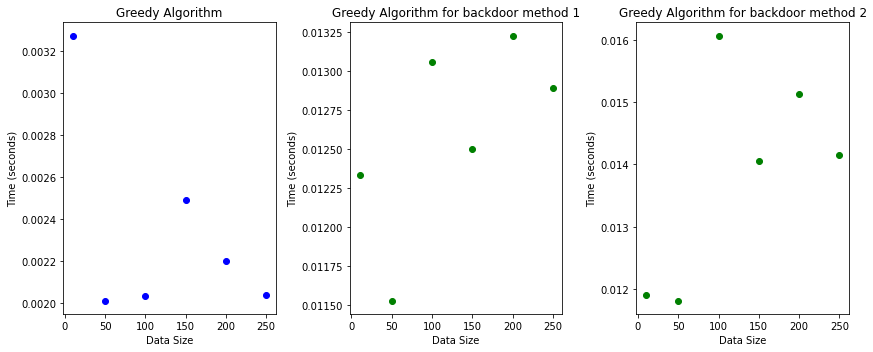

In [227]:
i_range=[10,50,100,150,200,250]
time_greedy_algo=[]
time_greedy_backdoor=[]
time_greedy_backdoor2=[]
df_rows=df.loc[row_indexes]
df_dropped = df.copy().drop(row_indexes)

for i in i_range:
    df_subsets=pd.concat([df_dropped.sample(i-5),df_rows])

    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G, df_subsets, 3, 'rating',var,0, {'edition':2},1, "add",2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G, df_subsets, 3, 'rating',var,1, {'edition':2} ,1, "add",2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G, df_subsets, 3, 'rating',var,1, {'edition':2} ,1, "add",2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)
    
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

axes[0].scatter(x=i_range, y=time_greedy_algo, color='blue')
axes[0].set_title('Greedy Algorithm')
axes[0].set_xlabel('Data Size')
axes[0].set_ylabel('Time (seconds)')

axes[1].scatter(x=i_range, y=time_greedy_backdoor, color='green')
axes[1].set_title('Greedy Algorithm for backdoor method 1')
axes[1].set_xlabel('Data Size')
axes[1].set_ylabel('Time (seconds)')

axes[2].scatter(x=i_range, y=time_greedy_backdoor2, color='green')
axes[2].set_title('Greedy Algorithm for backdoor method 2')
axes[2].set_xlabel('Data Size')
axes[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig(f'ranking_plots/time_comparision_data_amazon.png')
plt.show()

In [229]:
df.head(10)

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
0,The Staff Engineer's Path,A Guide for Individual Contributors Navigating...,Tanya Reilly,1098118731,978-1098118730,2022-10-25,1.0,1.0,No,5.0,0,0
1,Cracking the Coding Interview,189 Programming Questions and Solutions,Gayle Laakmann McDowell,984782869,978-0984782857,2015-07-01,6.0,1.0,No,5.0,0,0
2,"Python Crash Course, 3rd Edition","A Hands-On, Project-Based Introduction to Prog...",Eric Matthes,1718502702,978-1718502703,2023-01-10,3.0,1.0,No,5.0,0,0
6,"Automate the Boring Stuff with Python, 2nd Edi...",Practical Programming for Total Beginners,Al Sweigart,1593279922,978-1593279929,2019-11-12,2.0,1.0,No,5.0,0,0
7,The Manager's Path,A Guide for Tech Leaders Navigating Growth and...,Camille Fournier,1491973897,978-1491973899,2017-05-02,1.0,1.0,No,5.0,0,0
8,Design Patterns,Elements of Reusable Object-Oriented Software,Erich Gamma,201633612,978-0201633610,1994-10-31,1.0,1.0,No,5.0,0,0
10,The Pragmatic Programmer,"Your Journey To Mastery, 20th Anniversary Edit...",David Thomas,135957052,978-0135957059,2019-09-13,2.0,1.0,No,5.0,0,0
12,"Python Crash Course, 3rd Edition","A Hands-On, Project-Based Introduction to Prog...",Eric Matthes,1718502702,978-1718502703,2023-01-10,3.0,1.0,No,5.0,0,0
14,"Hands-On Machine Learning with Scikit-Learn, K...","Concepts, Tools, and Techniques to Build Intel...",Aurélien Géron,1098125975,978-1098125974,2022-11-08,3.0,1.0,No,5.0,0,0
15,Sql Guide (Quick Study,SQL),Inc. BarCharts,1572229160,978-1572229167,2005-01-01,1.0,1.0,No,4.0,0,0


In [246]:
df=df.drop_duplicates(subset=['title', 'edition'])

In [248]:
for i in range(10):
    tok_k_prob_df = ranking_funcs.get_ranking_query_prob(new_G, df, 3, {'edition':i}, 'rating',{'title':'Cracking the Coding Interview'},'fix')
    top3_ranking_probs = ranking_funcs.filter_prob_df(tok_k_prob_df)
    print(i)
    print('---------------')
    for idx in [0, 1, 2]:
        if idx in top3_ranking_probs.index:
            print(top3_ranking_probs.loc[idx])
        else:
            print(f"Index {idx} not found.")

0
---------------
row_index    0.000000
1            0.007353
2            0.007353
3            0.007353
Name: 0, dtype: float64
Index 1 not found.
row_index    2.000000
1            0.007353
2            0.007353
3            0.007353
Name: 2, dtype: float64
1
---------------
row_index    0.000000
1            0.007353
2            0.007353
3            0.007353
Name: 0, dtype: float64
Index 1 not found.
row_index    2.000000
1            0.007353
2            0.007353
3            0.007353
Name: 2, dtype: float64
2
---------------
row_index    0.000000
1            0.007353
2            0.007353
3            0.007353
Name: 0, dtype: float64
Index 1 not found.
row_index    2.000000
1            0.007353
2            0.007353
3            0.007353
Name: 2, dtype: float64
3
---------------
row_index    0.000000
1            0.007353
2            0.007353
3            0.007353
Name: 0, dtype: float64
Index 1 not found.
row_index    2.000000
1            0.007353
2            0.007353
3 

In [250]:
prob=0.007353*3

In [253]:
prob**3

1.0733897951379003e-05

In [270]:
0.007353**2

5.4066609e-05

In [258]:
prob

0.022059000000000002

In [263]:
prob**2

0.000216266436

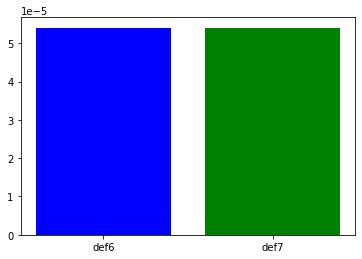

In [271]:
data = {'def6': 5.4066609e-05, 'def7': 5.4066609e-05}

labels = list(data.keys())
heights = list(data.values())

colors = ['blue', 'green']  


plt.bar(labels, heights, color=colors)

plt.savefig(f'ranking_plots/two_def_amazon.png')
plt.show()